In [6]:
import cv2
import sys, os
import numpy as np
import torch
from matplotlib import pyplot as plt
import pandas as pd
from collections import defaultdict

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
#from segment_anything import SamPredictor, sam_model_registry
from typing import List, Tuple
from custom_utils import load_images_and_boxes, plot_masks_on_images, save_masks, resize_images_and_masks, show_mask, show_points, show_box, show_masks

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cuda


In [8]:
# 이미지와 레이블 경로
image_folder = 'data/images/'
label_folder = 'data/labels/'
mask_output_folder = 'data/masks/'  # 마스크를 저장할 폴더 경로

sam2_checkpoint = '/home/oi/Desktop/song/cucumber-image/segment-anything-2/checkpoints/sam2_hiera_base_plus.pt'
model_cfg = "sam2_hiera_b_+.yaml"

In [9]:
sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device)
mask_predictor = SAM2ImagePredictor(sam2)


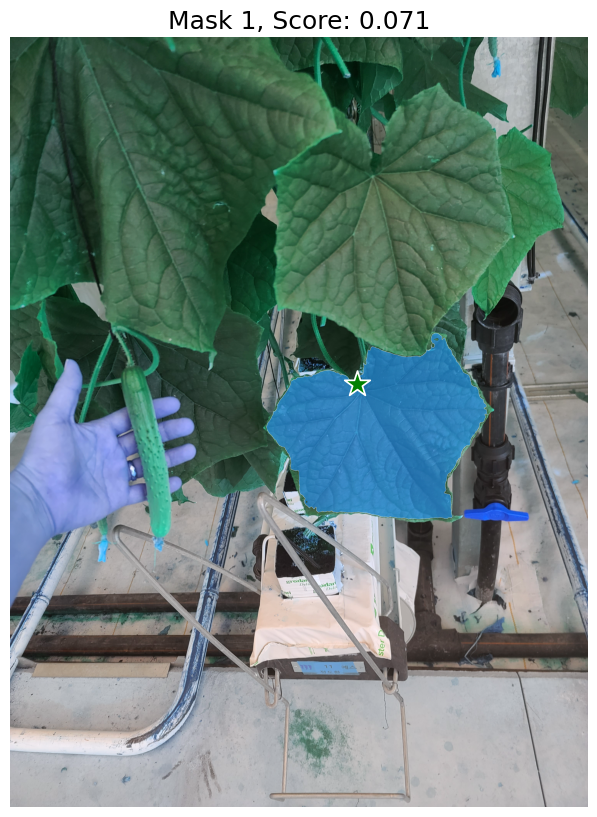

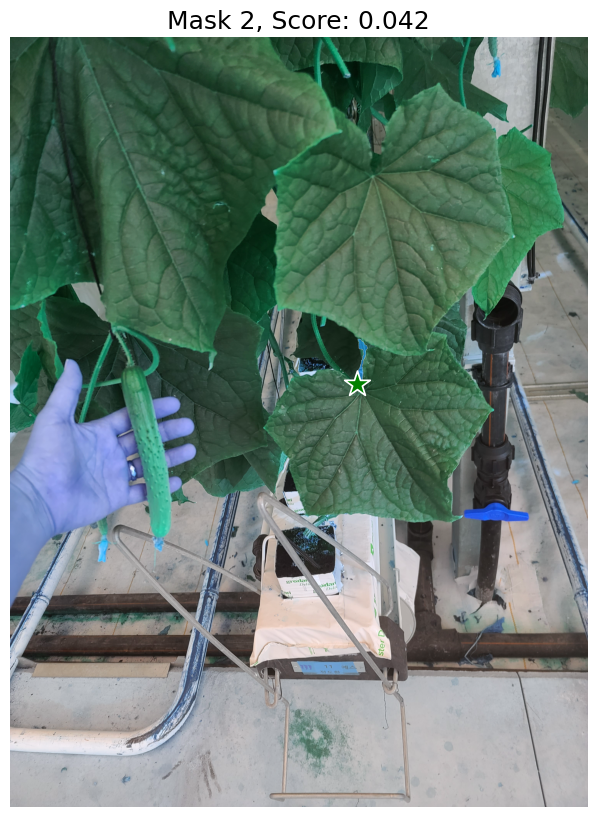

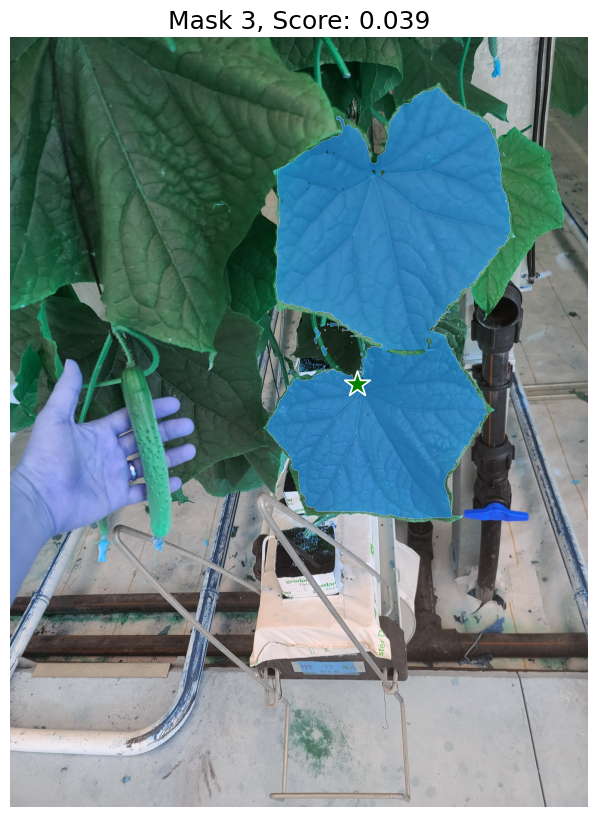

In [14]:
# 이미지 로드 및 RGB 변환
image_path = '/home/oi/Desktop/song/cucumber-image/data/images/V003_3_3_1_2_4_2_2_1_0_0_20221019_5319_20240422195059.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 포인트 좌표 설정 (차원 맞춤)
input_point = np.array([[1800, 1800]])  # 포인트 좌표 예시
input_label = np.array([1])  # positive point로 설정 (객체의 일부)
# input_point = torch.tensor([[[1800, 1000]]], dtype=torch.float, device='cuda')  # 디바이스에 맞게 할당
# input_label = torch.tensor([[1]], dtype=torch.int, device='cuda')  # 라벨도 텐서로 변환

# SAM 모델을 통한 마스크 예측
mask_predictor.set_image(image_rgb)
masks, scores, logits = mask_predictor.predict(
    box=None,
    multimask_output=True,
    point_coords=input_point,
    point_labels=input_label
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

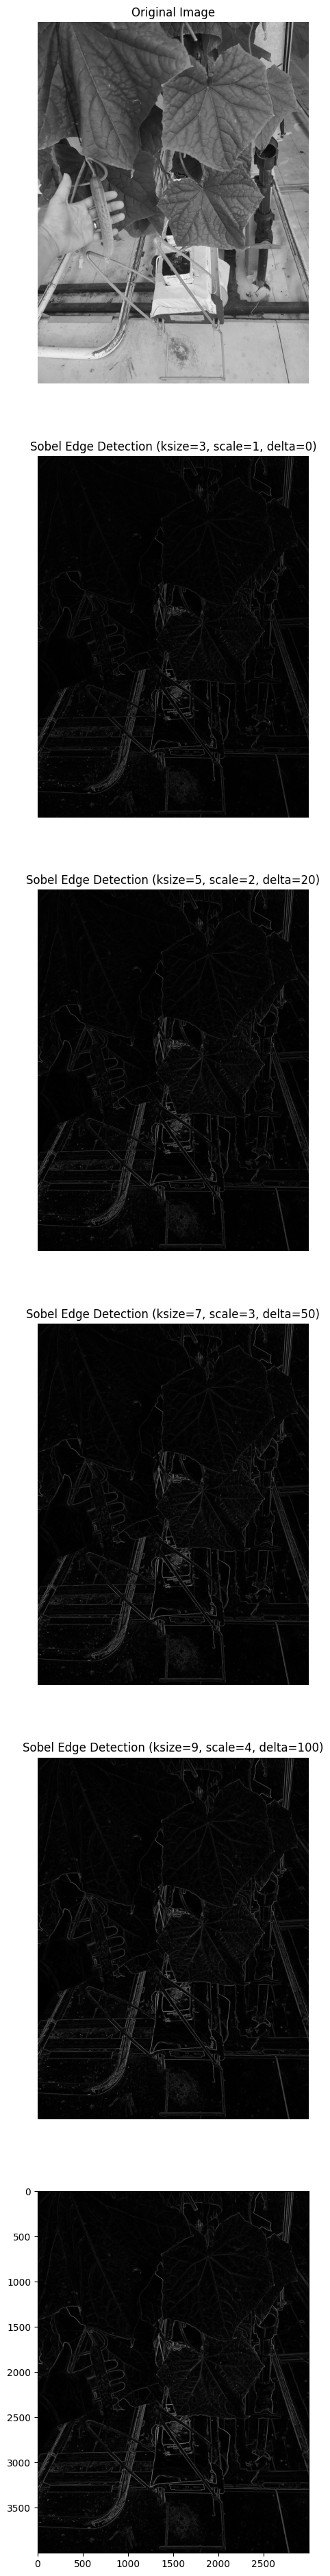

In [23]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 로드 (경로는 직접 설정하세요)
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # 이미지를 흑백으로 로드

# Sobel Filter 적용 - 파라미터 1: ksize=3, scale=1, delta=0
sobel_x1 = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3, scale=1, delta=0)
sobel_y1 = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3, scale=1, delta=0)
sobel_combined1 = cv2.magnitude(sobel_x1, sobel_y1)

# Sobel Filter 적용 - 파라미터 2: ksize=5, scale=2, delta=20
sobel_x2 = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5, scale=2, delta=20)
sobel_y2 = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5, scale=2, delta=20)
sobel_combined2 = cv2.magnitude(sobel_x2, sobel_y2)

# Sobel Filter 적용 - 파라미터 3: ksize=7, scale=3, delta=50
sobel_x3 = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=7, scale=3, delta=50)
sobel_y3 = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=7, scale=3, delta=50)
sobel_combined3 = cv2.magnitude(sobel_x3, sobel_y3)

# Sobel Filter 적용 - 파라미터 4: ksize=9, scale=4, delta=100 (더 강력하게)
sobel_x4 = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=9, scale=4, delta=100)
sobel_y4 = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=9, scale=4, delta=100)
sobel_combined4 = cv2.magnitude(sobel_x4, sobel_y4)

# Sobel Filter 적용 - 파라미터 5: ksize=11, scale=5, delta=150 (가장 강력하게)
sobel_x5 = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=11, scale=5, delta=150)
sobel_y5 = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=11, scale=5, delta=150)
sobel_combined5 = cv2.magnitude(sobel_x5, sobel_y5)

# 시각화
plt.figure(figsize=(24, 48))  # figsize를 조정하여 이미지 크기를 키움

# 원본 이미지
plt.subplot(6, 1, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Sobel Filter 결과 - 파라미터 1
plt.subplot(6, 1, 2)
plt.imshow(sobel_combined1, cmap='gray')
plt.title("Sobel Edge Detection (ksize=3, scale=1, delta=0)")
plt.axis('off')

# Sobel Filter 결과 - 파라미터 2
plt.subplot(6, 1, 3)
plt.imshow(sobel_combined2, cmap='gray')
plt.title("Sobel Edge Detection (ksize=5, scale=2, delta=20)")
plt.axis('off')

# Sobel Filter 결과 - 파라미터 3
plt.subplot(6, 1, 4)
plt.imshow(sobel_combined3, cmap='gray')
plt.title("Sobel Edge Detection (ksize=7, scale=3, delta=50)")
plt.axis('off')

# Sobel Filter 결과 - 파라미터 4
plt.subplot(6, 1, 5)
plt.imshow(sobel_combined4, cmap='gray')
plt.title("Sobel Edge Detection (ksize=9, scale=4, delta=100)")
plt.axis('off')

# Sobel Filter 결과 - 파라미터 5
plt.subplot(6, 1, 6)
plt.imshow(sobel_combined5, cmap='gray')
